# Why does it crash?

I started my first run (runscript: `exp.adiabat_20221210.run`) with boundary conditions warmed along a moist adiabat. It crashed after running for roughly an hour. Now we want to find out why. 

## Extracts from the log file

Here are some extracts from the log file (`/work/mh1126/m300872/eureca_icon/EUREC4A/run/logs/les_4k-adiabat-2907971.log`; line numbers included). The error that chrashes the run is evoked by a write routine:
```
13283038 3839: HDF5-DIAG: Error detected in HDF5 (1.12.1) thread 0:
13283039 3839:   #000: /home/k/k202066/.spack/stage/spack-stage-hdf5-1.12.1-tvymb53dysodq7atyt6kpvx4foh6wwog/spack-src/src/H5T.c line 1977 
         in H5Tclose(): not a datatype
13283040 3839:     major: Invalid arguments to routine
13283041 3839:     minor: Inappropriate type
```

But this is probably merely a symptom. Much earlier, strikingly exactly at 11:00h model time, a RTTOV control routine reports too high water vapour values. RTTOV is the module that generates the synthetic satellite images Hauke Schulz used for image classification of meso scale patterns.

```
16168    0:  Time step:      600, model time: 2020-01-09 11:00:00.000 forecast time 00D 01H00M00S
16169    0:  MAXABS VN, W in domain  1:  0.4047747258E+02 at level  38,   0.2091468433E+02 at level  80,
16170    0:  MAXABS VN, W in domain  1:  0.4047275206E+02 at level  38,   0.2094632978E+02 at level  79,
16171    0:  MAXABS VN, W in domain  1:  0.4046606764E+02 at level  38,   0.2098523454E+02 at level  79,
16172    0:  MAXABS VN, W in domain  1:  0.4045828277E+02 at level  38,   0.2103872305E+02 at level  79,
16173    0:  MAXABS VN, W in domain  1:  0.4045130131E+02 at level  41,   0.2107503192E+02 at level  79,
16174 1925:  2022/12/12  19:45:47  rttov_check_reg_limits.F90
16175 1925:      Input water vapour profile exceeds upper coef limit (profile number =        1)
16176 1925:  2022/12/12  19:45:47  Limit   =    17.8920   20.3040   33.5640
16177 1925:  2022/12/12  19:45:47  p (hPa) =    81.3744   97.1505  114.9415
16178 1925:  2022/12/12  19:45:47  Value   =    18.4693   24.1586   37.9187
```

The timing indicates that there is a problem with lateral boundary conditions, because boundary conditions are updated hourly. 

## Comparing lateral boundary conditions

As a first measure we will check, if there is something obviously off with lateral boundary conditions. 

In [1]:
import os

def extension(path):
    return os.path.splitext(path)[1]

def is_netcdf(f):
    return extension(f) == '.nc'

def get_filelist(lost_path, conserved_path):
    '''
    crawls the directory `lost_path`+`conserved_path` and 
    returns a list of files in all subdirectories. The returned 
    paths are relative paths to `lost_path`.
    '''
    file_list = []
    for root, directories,files in os.walk(os.path.join(lost_path, conserved_path)):
        for name in files: 
            if is_netcdf(name):
                path = os.path.join(os.path.relpath(root, start=lost_path), name)
                file_list.append(path)
    file_list.sort()
    return file_list

# a sound alarm to notify me, a cell has finished. i get distracted.
# https://gist.github.com/tamsanh/a658c1b29b8cba7d782a8b3aed685a24
from IPython.lib.display import Audio
import numpy as np

def beep(fr=4410, sec=1.0/7):
    t = np.linspace(0, sec*2, int(fr*sec))
    audio_data = np.sin(2*np.pi*300*t) + np.sin(2*np.pi*240*t)
    return Audio(audio_data, rate=4410, autoplay=True)

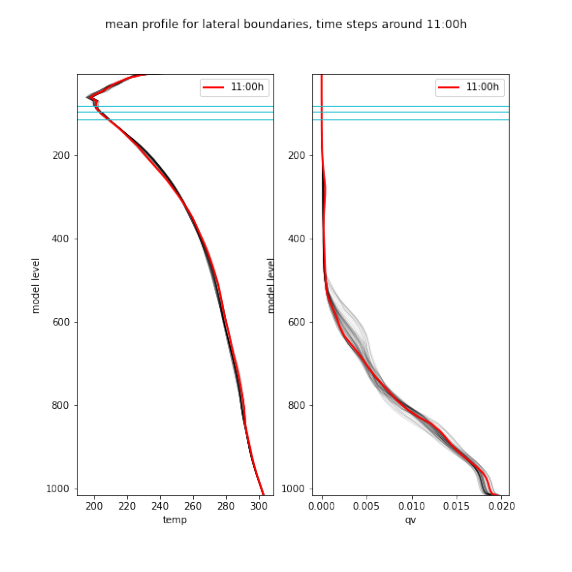

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import matplotlib.image as img
import plot_utils as pu

def plot_around_11(ax, data, varname ):
    var = data[varname].mean(dim='ncells')
    y_all = data['pres'].mean(dim='ncells')
    for i in range(len(var.time.values)):
        x = var.isel(time=i)
        y = y_all.isel(time=i) / 100
        kwargs = {'lw':0.2, 'color':'black', 'alpha':0.3, 'zorder':1}
        if str(x.time.values) == '2020-01-08T11:00:00.000000000': 
            kwargs = {'lw':2, 'color':'red', 'zorder':2, 'label':'11:00h'}
        ax.plot(x,y, **kwargs)
    for h in [81.3744, 97.1505, 114.9415]: ax.axhline(h, color='tab:cyan', lw=1)
    ax.legend()
    ax.set_xlabel(varname)
    ax.set_ylabel('model level')
    ax.set_ylim(np.min(y), np.max(y))
    ax.invert_yaxis()

def figure_mean_profile():
    directory_changed   = '/work/mh1126/m300872/moist_adiabatic/'
    directory_unchanged = '/work/mh1126/m300872/unchanged/'
    latbc = xr.open_mfdataset(get_filelist('', os.path.join(directory_changed,'latbc/'))[0:100])

    fig, axs = plt.subplots(1,2, figsize=(8,8))
    fig.suptitle('mean profile for lateral boundaries, time steps around 11:00h')
    plot_around_11(axs[0],latbc,'temp')
    plot_around_11(axs[1],latbc,'qv')
    return fig, axs

def make_if_missing(plot_function, savename, figsize=(10,15), sound_alarm=True):
    if not os.path.exists(savename):
        plot_function()
        plt.savefig(savename)
        if sound_alarm: beep()
    else:
        im = img.imread(savename)
        fig, ax = plt.subplots(figsize=figsize)
        ax.imshow(im)
        pu.remove_spines(ax)
        pu.remove_ticks(ax)

make_if_missing(figure_mean_profile, savename = 'img/mean_latbc_profiles_11.png')

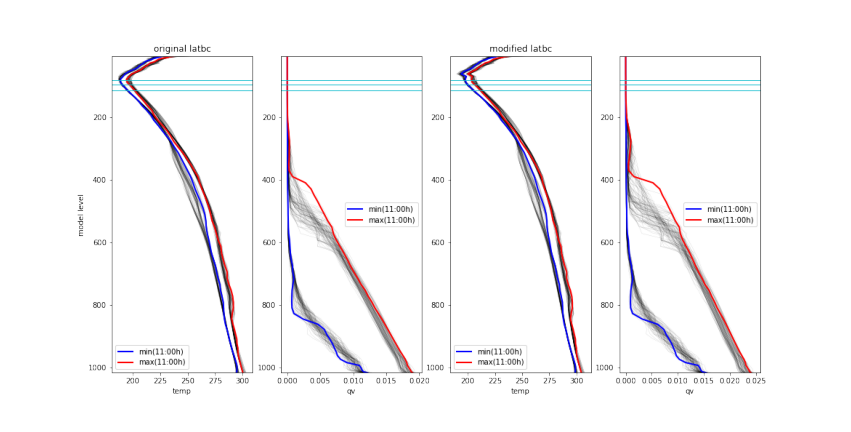

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

def plot_minmax_around_11(ax, data, varname):
    def get_kwargs(timestep, highlight_color, highlight_label):
        highlight_timestep = '2020-01-08T11:00:00.000000000'
        kwargs = {'lw':0.2, 'color':'black', 'alpha':0.3, 'zorder':1}
        highlight_kwargs = {'lw':2, 'color':highlight_color, 'zorder':2, 'label':highlight_label}
        if str(timestep) == highlight_timestep: kwargs = highlight_kwargs
        return kwargs
    
    maxima = data[varname].max(dim='ncells')
    minima = data[varname].min(dim='ncells')
    y_all = data['pres'].mean(dim='ncells')
    for i in range(len(maxima.time.values)):
        x_min = minima.isel(time=i)
        x_max = maxima.isel(time=i)
        y = y_all.isel(time=i) / 100
        ax.plot(x_min,y, **get_kwargs(x_min.time.values, 'blue', 'min(11:00h)'))
        ax.plot(x_max,y, **get_kwargs(x_min.time.values, 'red', 'max(11:00h)'))
    for h in [81.3744, 97.1505, 114.9415]: ax.axhline(h, color='tab:cyan', lw=1)
    
    ax.legend()
    ax.set_xlabel(varname)
    ax.set_ylabel('model level')
    ax.set_ylim(np.min(y), np.max(y))

def figure_minmax_profile():
    directory_changed   = '/work/mh1126/m300872/moist_adiabatic/'
    directory_unchanged = '/work/mh1126/m300872/unchanged/'
    fig, axs = plt.subplots(1,4, figsize=(16,8))
    latbc = xr.open_mfdataset(get_filelist('', os.path.join(directory_unchanged,'latbc/'))[0:100])
    axs[0].set_title('original latbc')
    plot_minmax_around_11(axs[0],latbc,'temp')
    plot_minmax_around_11(axs[1],latbc,'qv')
    latbc = xr.open_mfdataset(get_filelist('', os.path.join(directory_changed,'latbc/'))[0:100])
    axs[2].set_title('modified latbc')
    plot_minmax_around_11(axs[2],latbc,'temp')
    plot_minmax_around_11(axs[3],latbc,'qv')
    for ax in axs: ax.invert_yaxis()
    for ax in axs[1::]: ax.set_ylabel('')
    return fig, axs

make_if_missing(figure_minmax_profile, savename = 'img/minmax_latbc_profiles_11.png', figsize=(15,25))

## The output

In [4]:
import xarray as xr

def eureca_grid(domain='DOM01'):
    return xr.open_zarr(f"https://swift.dkrz.de/v1/dkrz_948e7d4bbfbb445fbff5315fc433e36a/grids/EUREC4A_PR1250m_{domain}.zarr")

directory = '/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/4kadiabat'
mask = '4kadiabat_DOM01_surface_'
file_list = [os.path.join(directory, f) for f in os.listdir(directory) if mask in f]
surf = xr.open_mfdataset(file_list).rename({'ncells':'cell'})
surf = xr.merge([eureca_grid(), surf]).drop_vars(list(eureca_grid()))

for var in list(surf):
    try:    print(var.ljust(15), surf[var].long_name)
    except: pass

u_10m           zonal wind in 10m
v_10m           meridional wind in 10m
rh_2m           relative humidity in 2m
t_2m            temperature in 2m
qv_2m           specific water vapor content in 2m
t_seasfc        sea surface temperature
shfl_s          surface sensible heat flux
lhfl_s          surface latent heat flux
tqv_dia         total column integrated water vapour (diagnostic)
tqc_dia         total column integrated cloud water (diagnostic)
tqi_dia         total column integrated cloud ice (diagnostic)
rain_gsp_rate   gridscale rain rate
tot_prec        total precip
clct            total cloud cover
pres_sfc        surface pressure


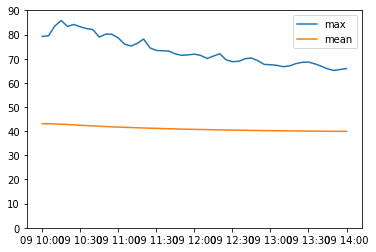

In [5]:
def icontime2numpytime(timefloat):
    date_string = str(int(timefloat))
    h_ = 24 * (timefloat - int(timefloat))
    h  = int(h_)
    m_ = 60 * (h_ - h)
    m  = int(np.round(m_))
    if m == 60: m = 0; h += 1
    return np.datetime64(f'{date_string[0:4]}-{date_string[4:6]}-{date_string[6:8]}T{str(h).rjust(2,"0")}:{str(m).rjust(2,"0")}')

vapor_max  = surf.tqv_dia.max(dim='cell').values
vapor_mean = surf.tqv_dia.mean(dim='cell').values
t = [icontime2numpytime(t) for t in surf.time.values]
fig, ax = plt.subplots()
ax.plot(t, vapor_max, label='max')
ax.plot(t, vapor_mean, label='mean')
ax.legend()
ax.set_ylim(0,90)
plt.show()

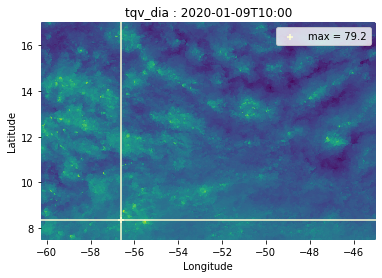

In [6]:
import numpy as np
import plot_utils as pu

t = 0

def plot_scatter_var(data, varname, timestep):
    s = data[varname].isel(time=timestep)
    fig, ax = plt.subplots()
    lon = np.rad2deg(s.clon)
    lat = np.rad2deg(s.clat)
    ax.scatter(lon, lat, 
               c=s, s=0.1)
    i_max = np.nanargmax(s.values)
    # print(i_max, lat.values[i_max])
    ax.axvline(lon.values[i_max], color='xkcd:eggshell')
    ax.axhline(lat.values[i_max], color='xkcd:eggshell')
    ax.scatter(lon.values[i_max], lat.values[i_max], label=f'max = {s.values[i_max]:.1f}', 
               color='xkcd:eggshell', marker='+')
    ax.set_xlim(np.min(lon),np.max(lon))
    ax.set_ylim(np.min(lat),np.max(lat))
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f'{varname} : {icontime2numpytime(s.time.values)}')
    ax.legend(loc='upper right')
    pu.remove_spines(ax)
    return fig, ax

varname  = 'tqv_dia'
timestep = 0  # surf.time.values.shape

plot_scatter_var(surf, varname, timestep)
plt.savefig(f'img/{varname}_{str(timestep).rjust(4,"0")}')
plt.show()

In [10]:
def create_frames(data, varname, indices, verbose=False):
    for timestep in indices:
        if verbose: print(timestep)
        fig, ax = plot_scatter_var(data, varname, timestep)
        plt.savefig(f'img/{varname}_{str(timestep).rjust(4,"0")}')
        plt.close(fig)

create_frames(surf, varname='tqv_dia', indices=[]) # indices=list(range(49))

In [36]:
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import numpy as np
import glob

fp_in = "img/tqv_dia_*.png"
fp_out = "img/tqv_dia_maxval.gif"

# https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html#gif
img, *imgs = [Image.open(f) for f in sorted(glob.glob(fp_in))]
img.save(fp=fp_out, format='GIF', append_images=imgs,
         save_all=True, duration=200, loop=0)

In [35]:
import matplotlib.pyplot as plt
import plot_utils as pu
import os
import xarray as xr

direc = '/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/4kadiabat/multifile_restart_atm_20200109T123000Z.mfr/'
patch1_path = '/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/4kadiabat/multifile_restart_atm_20200109T123000Z.mfr/patch1_0.nc'
mask  = 'patch1_'
files = [os.path.join(direc,f) for f in os.listdir(direc) if mask in f]
files.sort()

patches = []
for f in files:
    dat = xr.open_mfdataset(f)
    # print(dat.dims)
    patches.append(dat['qv.TL1'])
patches = xr.concat(patches, dim='ncells').isel(time=0)

<xarray.DataArray 'qv.TL1' (time: 1, height: 150, ncells: 4528560)>
dask.array<concatenate, shape=(1, 150, 4528560), dtype=float64, chunksize=(1, 150, 1497), chunktype=numpy.ndarray>
Coordinates:
  * height   (height) float64 1.0 2.0 3.0 4.0 5.0 ... 147.0 148.0 149.0 150.0
  * time     (time) float64 2.02e+07
Dimensions without coordinates: ncells
Attributes:
    long_name:      Specific humidity
    units:          kg kg-1
    CDI_grid_type:  unstructured

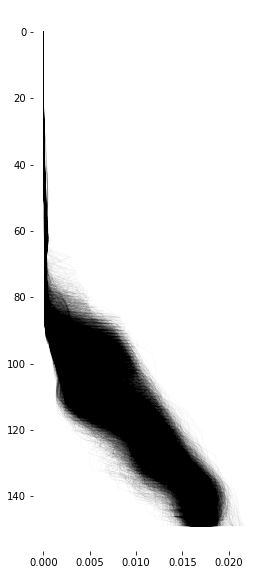

In [64]:
import numpy as np

y  = np.asarray(range(len(patches.isel(ncells=0))))
fig, ax = plt.subplots(figsize=(4,10))
ax.invert_yaxis()

kwargs = {'lw':0.2, 'color':'black', 'alpha':0.1}
plot_slice = slice(0,100)

cells = list(range(len(patches.ncells.values)))
for i in range(100):
    k = np.random.randint(len(cells))
    d = patches.isel(ncells=k)
    ax.plot(d, y, **kwargs)
pu.remove_spines(ax)
plt.show()

This could be done more efficiently, using [datashader](https://datashader.org/user_guide/Timeseries.html).

In the end the model did not crash, but ran through. RTTOV still gave Error messages, but they did not cause the run to crash. To investigate the source of these errors futher I could write out the upper model levels with high frequency. I could look into specific error messages and try to capture the specific time and place.